In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.feature_extraction.text import CountVectorizer
mpl.rcParams['patch.force_edgecolor'] = True
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import wordpunct_tokenize,sent_tokenize
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings("ignore")
%matplotlib inline

In [0]:
dataset = '../dataset/detecting-twitter-bot-data/'

## Datasets

In [0]:
training_data = pd.read_csv(dataset+'training_data_2_csv_UTF.csv')
test_data = pd.read_csv(dataset+'test_data_4_students.csv')
bots = training_data[training_data.bot==1]
nonbots = training_data[training_data.bot==0]

In [0]:
training_data.head()

,id,id_str,screen_name,location,description,url,followers_count,friends_count,listed_count,created_at,favourites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name,bot
0,8.160000e+17,"""815745789754417152""","""HoustonPokeMap""","""Houston, TX""","""Rare and strong PokŽmon in Houston, TX. See m...","""https://t.co/dnWuDbFRkt""",1291,0,10,"""Mon Jan 02 02:25:26 +0000 2017""",0,False,78554,"""en""","{\r ""created_at"": ""Sun Mar 12 15:44:04 +0...",True,False,False,"""Houston PokŽ Alert""",1
1,4.843621e+09,4843621225,kernyeahx,"Templeville town, MD, USA",From late 2014 Socium Marketplace will make sh...,NaN,1,349,0,2/1/2016 7:37,38,False,31,en,NaN,True,False,False,Keri Nelson,1
2,4.303727e+09,4303727112,mattlieberisbot,NaN,"Inspired by the smart, funny folks at @replyal...",https://t.co/P1e1o0m4KC,1086,0,14,Fri Nov 20 18:53:22 +0000 2015,0,False,713,en,"{'retweeted': False, 'is_quote_status': False,...",True,False,False,Matt Lieber Is Bot,1
3,3.063139e+09,3063139353,sc_papers,NaN,NaN,NaN,33,0,8,2/25/2015 20:11,0,False,676,en,Construction of human anti-tetanus single-chai...,True,True,False,single cell papers,1
4,2.955142e+09,2955142070,lucarivera16,"Dublin, United States",Inspiring cooks everywhere since 1956.,NaN,11,745,0,1/1/2015 17:44,146,False,185,en,NaN,False,False,False,lucarivera16,1


## Visuals

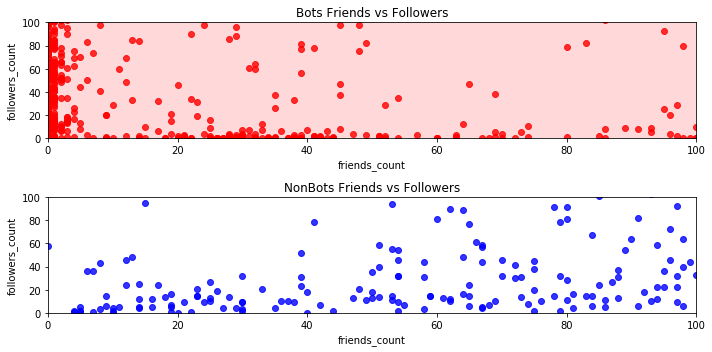

In [0]:
bots.friends_count/bots.followers_count

plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('Bots Friends vs Followers')
sns.regplot(bots.friends_count, bots.followers_count, color='red', label='Bots')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.tight_layout()

plt.subplot(2,1,2)
plt.title('NonBots Friends vs Followers')
sns.regplot(nonbots.friends_count, nonbots.followers_count, color='blue', label='NonBots')
plt.xlim(0, 100)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

In [0]:
training_data['bot'].value_counts()

0    1476
1    1321
Name: bot, dtype: int64

(504, 21)


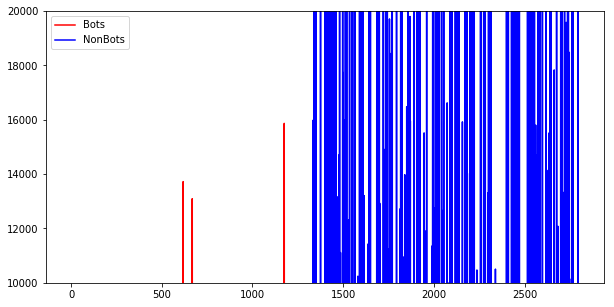

In [0]:
bots['friends_by_followers'] = bots.friends_count/bots.followers_count
bots[bots.friends_by_followers<1].shape

nonbots['friends_by_followers'] = nonbots.friends_count/nonbots.followers_count
nonbots[nonbots.friends_by_followers<1].shape


plt.figure(figsize=(10,5))
plt.plot(bots.listed_count, color='red', label='Bots')
plt.plot(nonbots.listed_count, color='blue', label='NonBots')
plt.legend(loc='upper left')
plt.ylim(10000,20000)
print(bots[(bots.listed_count<5)].shape)


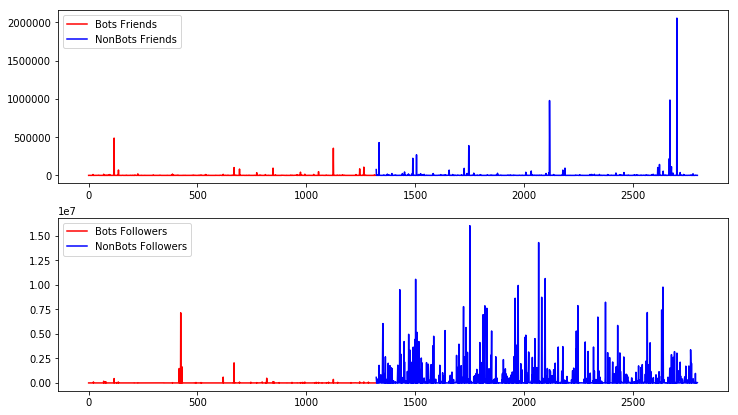

In [0]:

bots_listed_count_df = bots[bots.listed_count<16000]
nonbots_listed_count_df = nonbots[nonbots.listed_count<16000]

bots_verified_df = bots_listed_count_df[bots_listed_count_df.verified==False]
bots_screenname_has_bot_df_ = bots_verified_df[(bots_verified_df.screen_name.str.contains("bot", case=False)==True)].shape

plt.figure(figsize=(12,7))

plt.subplot(2,1,1)
plt.plot(bots_listed_count_df.friends_count, color='red', label='Bots Friends')
plt.plot(nonbots_listed_count_df.friends_count, color='blue', label='NonBots Friends')
plt.legend(loc='upper left')

plt.subplot(2,1,2)
plt.plot(bots_listed_count_df.followers_count, color='red', label='Bots Followers')
plt.plot(nonbots_listed_count_df.followers_count, color='blue', label='NonBots Followers')
plt.legend(loc='upper left')

In [0]:

#bots[bots.listedcount>10000]
condition = (bots.screen_name.str.contains("bot", case=False)==True)|(bots.description.str.contains("bot", case=False)==True)|(bots.location.isnull())|(bots.verified==False)

bots['screen_name_binary'] = (bots.screen_name.str.contains("bot", case=False)==True)
bots['location_binary'] = (bots.location.isnull())
bots['verified_binary'] = (bots.verified==False)
bots.shape

(1321, 24)

In [0]:
condition = (nonbots.screen_name.str.contains("bot", case=False)==False)| (nonbots.description.str.contains("bot", case=False)==False) |(nonbots.location.isnull()==False)|(nonbots.verified==True)

nonbots['screen_name_binary'] = (nonbots.screen_name.str.contains("bot", case=False)==False)
nonbots['location_binary'] = (nonbots.location.isnull()==False)
nonbots['verified_binary'] = (nonbots.verified==True)

nonbots.shape

(1476, 24)

In [0]:
df = pd.concat([bots, nonbots])
df.shape

(2797, 24)

## Spearman

In [0]:
df.corr(method='spearman')


,id,followers_count,friends_count,listed_count,favourites_count,verified,statuses_count,default_profile,default_profile_image,bot,friends_by_followers,screen_name_binary,location_binary,verified_binary
id,1.000000,-0.672925,-0.402346,-0.615005,-0.439430,-0.611899,-0.451945,0.522990,0.166601,0.652131,0.270435,-0.576100,-0.228328,0.150100
followers_count,-0.672925,1.000000,0.375522,0.896126,0.457363,0.709732,0.649117,-0.496899,-0.293838,-0.468430,-0.577157,0.458213,0.189675,0.130717
friends_count,-0.402346,0.375522,1.000000,0.204403,0.641529,0.356452,0.111118,-0.296358,-0.097607,-0.483105,0.427638,0.342145,0.082692,-0.210592
listed_count,-0.615005,0.896126,0.204403,1.000000,0.349059,0.694340,0.684976,-0.447376,-0.269035,-0.318445,-0.681034,0.338698,0.188797,0.281360
favourites_count,-0.439430,0.457363,0.641529,0.349059,1.000000,0.394227,0.295108,-0.348043,-0.226956,-0.526228,0.104797,0.408864,0.120941,-0.220894
verified,-0.611899,0.709732,0.356452,0.694340,0.394227,1.000000,0.333278,-0.404650,-0.132298,-0.508555,-0.419815,0.434177,0.191922,0.346505
statuses_count,-0.451945,0.649117,0.111118,0.684976,0.295108,0.333278,1.000000,-0.375918,-0.289999,-0.089018,-0.533971,0.162213,0.105333,0.207384
default_profile,0.522990,-0.496899,-0.296358,-0.447376,-0.348043,-0.404650,-0.375918,1.000000,0.246979,0.407748,0.197929,-0.377572,-0.138378,0.072351
default_profile_image,0.166601,-0.293838,-0.097607,-0.269035,-0.226956,-0.132298,-0.289999,0.246979,1.000000,0.139669,0.190986,-0.166388,0.000596,0.033021
bot,0.652131,-0.468430,-0.483105,-0.318445,-0.526228,-0.508555,-0.089018,0.407748,0.139669,1.000000,-0.044056,-0.843429,-0.266342,0.606771


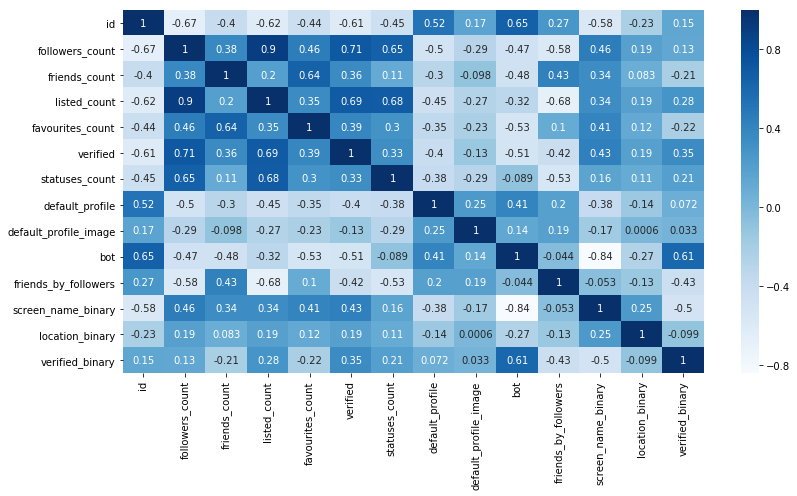

In [0]:

plt.figure(figsize=(12,7))
sns.heatmap(df.corr(method='spearman'), cmap='Blues', annot=True)
plt.tight_layout()
plt.show()

In [0]:

training_data['screen_name'][:10]

0    "HoustonPokeMap"
1           kernyeahx
2     mattlieberisbot
3           sc_papers
4        lucarivera16
5      dantheimprover
6         _all_of_us_
7       KatamariItems
8     AutophagyPapers
9          HSC_papers
Name: screen_name, dtype: object

In [0]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n],bag_of_words

def get_filtered(text):
    word_list = [i.lower() for i in wordpunct_tokenize(text) if i.lower() not in stop_words]
    return ' '.join(word_list)

def get_count_df(corpus,n=None):
    freq,_ = get_top_n_words(corpus,n)
    words = []
    count = []
    for i in freq:
        words.append(i[0])
        count.append(i[1])
    df = pd.concat([pd.Series(words),pd.Series(count)],axis = 1)
    df.columns = 'Words Occurences'.split()
    return df

In [0]:
bots_des = get_count_df(bots['description'].fillna('').apply(get_filtered),50)
nobots_des = get_count_df(nonbots['description'].fillna('').apply(get_filtered),50)

bots_desc = ' '.join(description for description in bots['description'].fillna(''))
nonbots_desc = ' '.join(description for description in nonbots['description'].fillna(''))

In [0]:
bots_des.head(10)

,Words,Occurences
0,bot,316
1,co,141
2,every,92
3,tweets,89
4,https,78
5,follow,78
6,tweet,70
7,http,63
8,botally,63
9,twitter,60


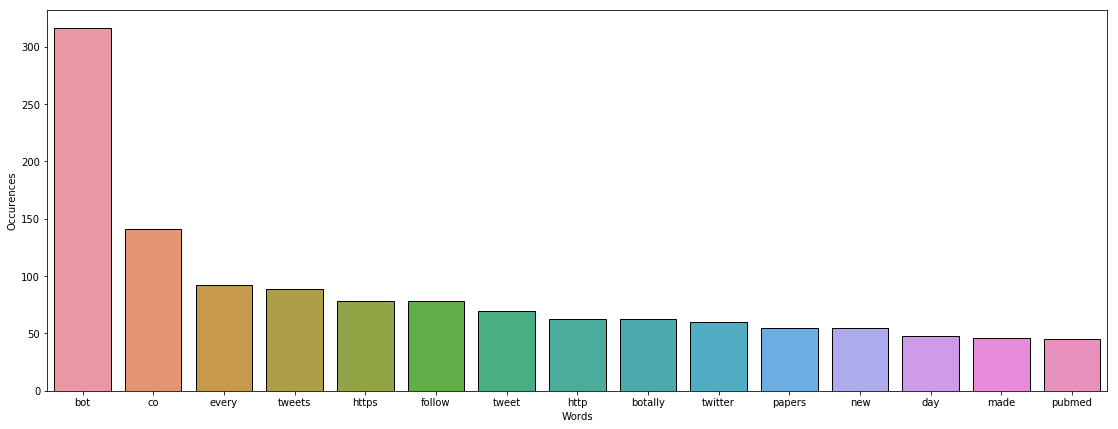

In [0]:
plt.figure(figsize=(19,7))
sns.barplot(x = 'Words', y = 'Occurences', data = bots_des[:15], ci= None)

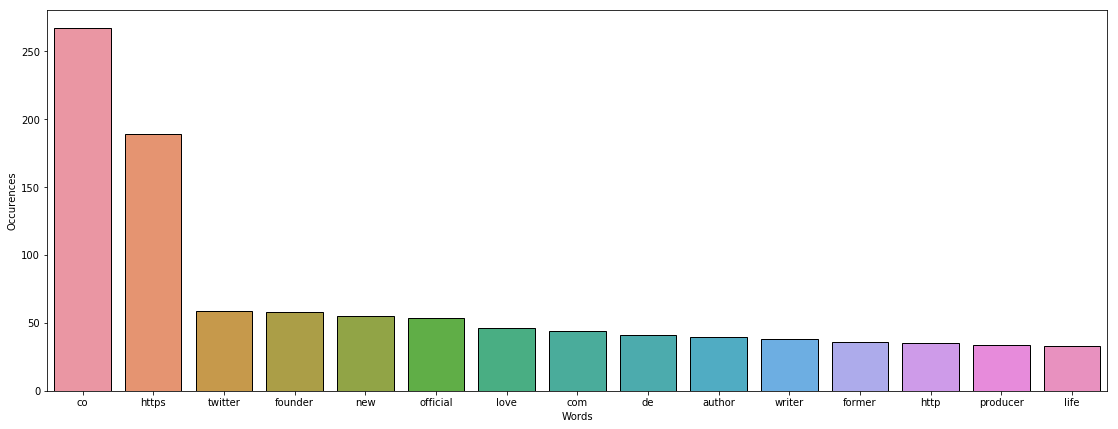

In [0]:
plt.figure(figsize=(19,7))
sns.barplot(x = 'Words', y = 'Occurences', data = nobots_des[:15], ci= None)

In [0]:
nobots_des.head(10)

,Words,Occurences
0,co,267
1,https,189
2,twitter,59
3,founder,58
4,new,55
5,official,54
6,love,46
7,com,44
8,de,41
9,author,40


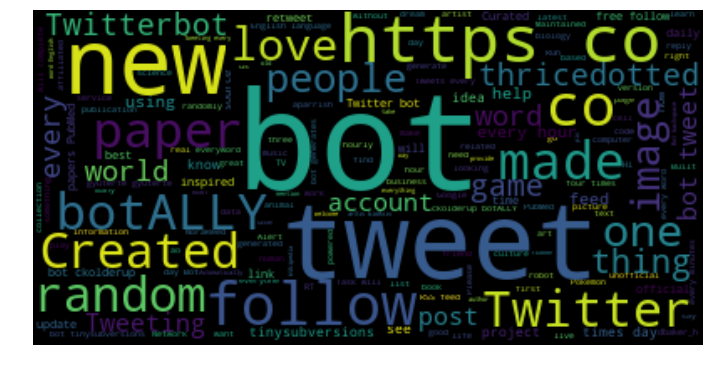

In [0]:
text = bots_desc
plt.figure(figsize=(12,7))
wordcloud = WordCloud().generate(text)# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

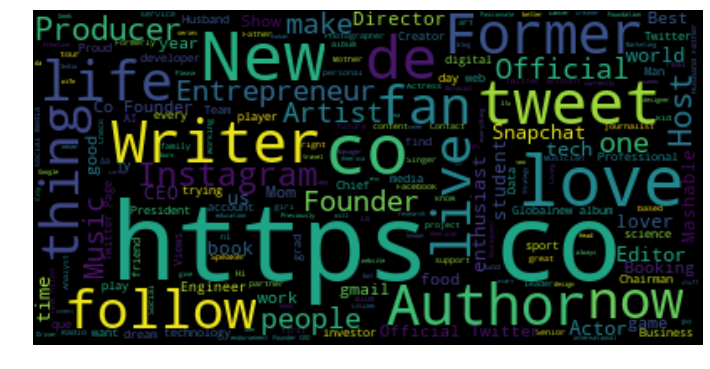

In [0]:
text = nonbots_desc
plt.figure(figsize=(12,7))
wordcloud = WordCloud().generate(text)# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Preparing data for analysis

In [0]:
bag_of_words_bot = r'bot|b0t|cannabis|tweet me|mishear|follow me|updates every|gorilla|yes_ofc|forget' \
                    r'expos|kill|clit|bbb|butt|fuck|XXX|sex|truthe|fake|anony|free|virus|funky|RNA|kuck|jargon' \
                    r'nerd|swag|jack|bang|bonsai|chick|prison|paper|pokem|xx|freak|ffd|dunia|clone|genie|bbb' \
                    r'ffd|onlyman|emoji|joke|troll|droop|free|every|wow|cheese|yeah|bio|magic|wizard|face'
            
training_data['screen_name_binary'] = training_data.screen_name.str.contains(bag_of_words_bot, case=False, na=False)
training_data['name_binary'] = training_data.name.str.contains(bag_of_words_bot, case=False, na=False)
training_data['description_binary'] = training_data.description.str.contains(bag_of_words_bot, case=False, na=False)
training_data['status_binary'] = training_data.status.str.contains(bag_of_words_bot, case=False, na=False)

test_data['screen_name_binary'] = test_data.screen_name.str.contains(bag_of_words_bot, case=False, na=False)
test_data['name_binary'] = test_data.name.str.contains(bag_of_words_bot, case=False, na=False)
test_data['description_binary'] = test_data.description.str.contains(bag_of_words_bot, case=False, na=False)
test_data['status_binary'] = test_data.status.str.contains(bag_of_words_bot, case=False, na=False)

In [0]:
def x(temp):
    if temp == 'None':
        return 0
    else:
        return temp
test_data['listed_count'] = test_data['listed_count'].apply(lambda x: 0 if x == 'None' else x).astype(int)

In [0]:
training_data['listed_count_binary'] = (training_data.listed_count>20000)==False
test_data['listed_count_binary'] = (test_data.listed_count>20000)==False
features = ['screen_name_binary', 'name_binary', 'description_binary', 'status_binary', 'verified', 'followers_count', 'friends_count', 'statuses_count', 'listed_count_binary', 'bot']

#features = ['verified', 'followers_count', 'friends_count', 'statuses_count', 'listed_count_binary', 'bot']

## Kfold and etc

In [0]:
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

In [0]:
def skfold(X, y, model):
    skf = StratifiedKFold(n_splits=10)
    skf.get_n_splits(X, y)
    results = cross_val_score(model, X, y, cv=skf,scoring='f1')
    return results

def print_acc(results,model):
    print("Accuracy of {} is {} and std is {}" .format(model ,results.mean()*100, results.std()*100))

In [0]:

X_train, X_test, Y_train, Y_test = train_test_split(training_data[features].iloc[:,:-1],\
                                                    training_data[features].iloc[:,-1], test_size=0.33, random_state=42)

In [0]:

xgb_s = skfold(X_train, Y_train, xgboost.XGBClassifier());
gnb_s = skfold(X_train, Y_train, GaussianNB());
rf_s = skfold(X_train, Y_train,RandomForestClassifier());
svc_s = skfold(X_train, Y_train,SVC());
ada_s = skfold(X_train, Y_train,AdaBoostClassifier());
knn_s = skfold(X_train, Y_train,KNeighborsClassifier());
MLPc_s = skfold(X_train, Y_train,MLPClassifier());
dic_s = {'XGB':xgb_s, 'RandomForest':rf_s,'SVC':svc_s,'GaussianNB':gnb_s,'adaBoost':ada_s,'KNN':knn_s, 'MLPc':MLPc_s}
dic_s

{'XGB': array([0.87573964, 0.90588235, 0.93641618, 0.83428571, 0.88235294,
        0.90697674, 0.88235294, 0.89142857, 0.89502762, 0.93854749]),
 'RandomForest': array([0.86549708, 0.87292818, 0.92045455, 0.80924855, 0.8742515 ,
        0.89411765, 0.89411765, 0.89265537, 0.87150838, 0.93406593]),
 'SVC': array([0.1443299 , 0.16161616, 0.23762376, 0.14      , 0.2020202 ,
        0.18181818, 0.18      , 0.2       , 0.14141414, 0.23529412]),
 'GaussianNB': array([0.74261603, 0.70916335, 0.69803922, 0.6848249 , 0.72653061,
        0.70119522, 0.72064777, 0.67424242, 0.68725869, 0.69803922]),
 'adaBoost': array([0.82424242, 0.80239521, 0.9112426 , 0.80232558, 0.85882353,
        0.86206897, 0.79761905, 0.89385475, 0.86666667, 0.93333333]),
 'KNN': array([0.79347826, 0.80645161, 0.79120879, 0.76190476, 0.78651685,
        0.80213904, 0.85082873, 0.82978723, 0.76666667, 0.82051282]),
 'MLPc': array([0.74468085, 0.71568627, 0.69230769, 0.70588235, 0.79754601,
        0.74654378, 0.72527473, 0

Accuracy of XGBOOST is 89.49010205478872 and std is 2.8745941938804647
Accuracy of Random Forest is 88.28844825496287 and std is 3.2259157898563227
Accuracy of SVC  is 18.241164637992 and std is 3.4506756421688363
Accuracy of gnb  is 70.42557430613972 and std is 1.9784789428385123
Accuracy of adab  is 85.52572109920312 and std is 4.559554008242485
Accuracy of knn  is 80.09494768755891 and std is 2.6062944005488586
Accuracy of mlp  is 73.05392883331795 and std is 3.628192856794458






Text(0, 0.5, '%accuracy')

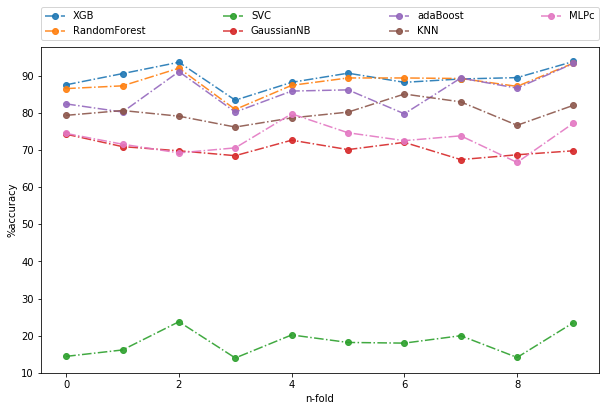

In [0]:
print_acc(xgb_s, 'XGBOOST')
print_acc(rf_s, 'Random Forest')
print_acc(svc_s, 'SVC ')
print_acc(gnb_s, 'gnb ')
print_acc(ada_s, 'adab ')
print_acc(knn_s, 'knn ')
print_acc(MLPc_s, 'mlp ')

print('\n\n\n')

results_s = pd.DataFrame(dic_s).applymap(lambda x: x*100)
results_s.plot(**{'linewidth':1.5, 'linestyle':'-.','marker':'o',\
                     'alpha':.9,'figsize':(10,6)})
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=4)
plt.xlabel('n-fold')
plt.ylabel('%accuracy')

## Grid Search and all

In [0]:
params = {
       'min_child_weight': [1, 5, 10],
       'gamma': [0.5, 1, 1.5, 2, 5],
       'subsample': [0.6, 0.8, 1.0],
       'colsample_bytree': [0.6, 0.8, 1.0],
       'max_depth': [3, 4, 5]
       }
xgb = xgboost.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                   silent=True, nthread=1)
folds = 5
param_comb = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
grid = GridSearchCV(estimator=xgb, param_grid=params, scoring='roc_auc',
                   n_jobs=4, cv=skf.split(X_train, Y_train), verbose=3)
grid.fit(X_train, Y_train)
print('\n Best estimator:')
print(grid.best_estimator_)
print('\n Best score:')
print(grid.best_score_ * 2 - 1)
print('\n Best parameters:')
print(grid.best_params_)



In [0]:
xgb = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=1.5, learning_rate=0.02,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators=600, n_jobs=1, nthread=1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1.0)
bst = xgb.fit(X_train, Y_train)
print("Start Predicting")
predictions = bst.predict(X_test)
pred_proba = bst.predict_proba(X_test)[:, 1]
from sklearn.metrics import classification_report
print(classification_report(Y_test, predictions))



Start Predicting
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       493
           1       0.90      0.85      0.88       431

   micro avg       0.89      0.89      0.89       924
   macro avg       0.89      0.89      0.89       924
weighted avg       0.89      0.89      0.89       924

